In [36]:
#모듈 로딩
# Model 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torchmetrics.classification import F1Score,BinaryF1Score,BinaryAccuracy,BinaryConfusionMatrix
import torch.optim.lr_scheduler as lr_scheduler 


# Data 및 시각화 관련
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
class make_dataset(Dataset):
    def __init__(self,featureDF,targetDF) -> None:
        super().__init__()
        # self.DF = DF
        self.targetDF = targetDF
        self.featureDF = featureDF
        self.n_rows = featureDF.shape[0]
        self.n_features = featureDF.shape[1]
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'        
    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        # 텐서화
        featureTS = torch.FloatTensor(self.featureDF.iloc[index].values).to(self.device)
        targetTS = torch.FloatTensor(self.targetDF.iloc[index].values).to(self.device)

        # 피쳐와 타겟 반환
        return featureTS, targetTS

In [38]:
class dynamic_bcf_Model(nn.Module):
    # 모델구조 구성 및 인스턴스 생성 메서드
    def __init__(self,in_in,* in_out):
        super().__init__()
        self.in_layer = nn.Linear(in_in,in_out[0])
        self.h_layer = nn.ModuleList([nn.Linear(in_out[i],in_out[i+1]) for i in range(len(in_out)-1)])
        self.out_layer = nn.Linear(in_out[-1],1)

    # 순방향 학습 진행 메서드
    def forward(self,x):
        y=self.in_layer(x)      # f1w1 + f2w2 + f3w3 + b 결과 10
        y=F.relu(y)             # 0 <= y
        for layer in self.h_layer:
            y=layer(y)
            y=F.relu(y)
        return F.sigmoid(self.out_layer(y))  

In [39]:
mbti_df=pd.read_csv('../data/MBTI.csv')
mbti_df

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ
...,...,...
106062,stay frustrate world life want take long nap w...,INFP
106063,fizzle around time mention sure mistake thing ...,INFP
106064,schedule modify hey w intp strong wing underst...,INFP
106065,enfj since january busy schedule able spend li...,INFP


In [40]:
sampled_df = mbti_df.groupby('type', group_keys=False).apply(lambda x: x.sample(n=40, random_state=42))
sampled_df['type'].value_counts()

type
ENFJ    40
ENFP    40
ENTJ    40
ENTP    40
ESFJ    40
ESFP    40
ESTJ    40
ESTP    40
INFJ    40
INFP    40
INTJ    40
INTP    40
ISFJ    40
ISFP    40
ISTJ    40
ISTP    40
Name: count, dtype: int64

In [41]:
feature_df=sampled_df['posts']

In [42]:
target_df=sampled_df['type'].str.contains('E')
target_df

54944     True
53656     True
53896     True
54669     True
54936     True
         ...  
51025    False
50985    False
51818    False
52883    False
50996    False
Name: type, Length: 640, dtype: bool

In [43]:
#E=0, I=1
target_df=np.array(target_df.astype('int8'))

In [44]:
#문자열 데이터를 벡터화
TfidfVectorizer(stop_words='english')
vectorizer = TfidfVectorizer(max_features=1000,min_df=5)
vectorizer = vectorizer.fit(sampled_df['posts'].to_numpy().reshape(-1))

In [45]:
vds = []
vts = []
for i,e in enumerate(feature_df.to_numpy()):
    dataStr = e.split(' ')
    npStr = np.array(dataStr).reshape(-1)
    for v in vectorizer.transform(npStr).toarray():
        vds.append(v)
        vts.append(target_df[i])

In [46]:
feature_df=pd.DataFrame(vds)
target_df=pd.DataFrame(vts)

In [47]:
print(feature_df.shape,feature_df.ndim)
print(target_df.shape,target_df.ndim)

(320575, 1000) 2
(320575, 1) 2


In [48]:
x_train, x_test, y_train, y_test = train_test_split(feature_df,target_df,stratify=target_df, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,stratify=y_train, test_size=0.2, random_state=1)

In [49]:
model=dynamic_bcf_Model(1000,900,800,700,600,500,400,300,200,100,50,25,15,10,5)
print(model)

dynamic_bcf_Model(
  (in_layer): Linear(in_features=1000, out_features=900, bias=True)
  (h_layer): ModuleList(
    (0): Linear(in_features=900, out_features=800, bias=True)
    (1): Linear(in_features=800, out_features=700, bias=True)
    (2): Linear(in_features=700, out_features=600, bias=True)
    (3): Linear(in_features=600, out_features=500, bias=True)
    (4): Linear(in_features=500, out_features=400, bias=True)
    (5): Linear(in_features=400, out_features=300, bias=True)
    (6): Linear(in_features=300, out_features=200, bias=True)
    (7): Linear(in_features=200, out_features=100, bias=True)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=25, bias=True)
    (10): Linear(in_features=25, out_features=15, bias=True)
    (11): Linear(in_features=15, out_features=10, bias=True)
    (12): Linear(in_features=10, out_features=5, bias=True)
  )
  (out_layer): Linear(in_features=5, out_features=1, bias=True)
)


In [50]:
x_train.shape[0]//200

1025

In [51]:
train_ds=make_dataset(x_train,y_train)
val_ds=make_dataset(x_val,y_val)
test_ds=make_dataset(x_test,y_test)

train_dl=DataLoader(train_ds,batch_size=x_train.shape[0]//200)

for feature,target in train_dl:
    print(feature.shape,target.shape, feature,target)
    break

torch.Size([1025, 1000]) torch.Size([1025, 1]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([[1.],
        [0.],
        [1.],
        ...,
        [0.],
        [1.],
        [0.]])


In [52]:
optimizer=optim.Adam(model.parameters(),lr=0.002)

binary_loss=nn.BCELoss()

In [53]:
loss_history=[[],[]]
score_history=[[],[]]

EPOCH=100

break_count=0
limit=20

for epoch in range(EPOCH):
    model.train()

    total_loss=0
    total_score=0

    for feature, target in train_dl:
        #학습 진행
        pre_y=model(feature)

        #손실 계산
        loss=binary_loss(pre_y,target)
        total_loss+=loss.item()

        #성능평가
        score=BinaryF1Score()(pre_y,target)
        total_score+=score.item()

        #최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 에포크 당 검증
    model.eval()

    with torch.no_grad():
        #검증데이터셋
        val_feature=val_ds[:][0]
        val_target=val_ds[:][1]

        #평가
        pre_val=model(val_feature)

        #손실
        loss_val=binary_loss(pre_val,val_target)
        
        #성능평가
        score_val=BinaryF1Score()(pre_val,val_target)

    # 손실값과 성능악악값 저장
    loss_history[0].append(total_loss/len(train_dl))
    score_history[0].append(total_score/len(train_dl))

    loss_history[1].append(loss_val)
    score_history[1].append(score_val)

    print(f'[{epoch}/{EPOCH}]\n- Train Loss : {loss_history[0][-1]} Score : {score_history[0][-1]}')
    print(f'- Val Loss : {loss_history[1][-1]} Score : {score_history[1][-1]}')

    #score
    if len(score_history[1])>=2:
        if score_history[1][-1] <= score_history[1][-2]: break_count+=1

    #학습 중단 여부 설정
    if break_count>limit:
        print(f'성능 및 손실 개선이 없어서 {epoch} EPOCH에 학습 중단')
        break

[0/100]
- Train Loss : 0.6933723616955886 Score : 0.0
- Val Loss : 0.6931523084640503 Score : 0.0
[1/100]
- Train Loss : 0.6931500452667919 Score : 0.600634711595317
- Val Loss : 0.6931459903717041 Score : 0.6673768162727356
[2/100]
- Train Loss : 0.6931500529768455 Score : 0.6674346315920057
- Val Loss : 0.6931460499763489 Score : 0.6673768162727356
[3/100]
- Train Loss : 0.6931501698138108 Score : 0.6674346315920057
- Val Loss : 0.6931461095809937 Score : 0.6673768162727356
[4/100]
- Train Loss : 0.6931502285288341 Score : 0.6674346315920057
- Val Loss : 0.6931459903717041 Score : 0.6673768162727356
[5/100]
- Train Loss : 0.6931502647067777 Score : 0.6674346315920057
- Val Loss : 0.6931461095809937 Score : 0.6673768162727356
[6/100]
- Train Loss : 0.6931502884300194 Score : 0.6674346315920057
- Val Loss : 0.6931459903717041 Score : 0.6673768162727356
[7/100]
- Train Loss : 0.6931503068155317 Score : 0.6674346315920057
- Val Loss : 0.6931459903717041 Score : 0.6673768162727356
[8/100]

In [ ]:
loss_history=[[],[]]
score_history=[[],[]]

EPOCH=100

break_count=0
limit=20

for epoch in range(EPOCH):
    model.train()

    total_loss=0
    total_score=0

    for feature, target in train_dl:
        #학습 진행
        pre_y=model(feature)

        #손실 계산
        loss=binary_loss(pre_y,target)
        total_loss+=loss.item()

        #성능평가
        score=BinaryF1Score()(pre_y,target)
        total_score+=score.item()

        #최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 에포크 당 검증
    model.eval()

    with torch.no_grad():
        #검증데이터셋
        val_feature=val_ds[:][0]
        val_target=val_ds[:][1]

        #평가
        pre_val=model(val_feature)

        #손실
        loss_val=binary_loss(pre_val,val_target)
        
        #성능평가
        score_val=BinaryF1Score()(pre_val,val_target)

    # 손실값과 성능악악값 저장
    loss_history[0].append(total_loss/len(train_dl))
    score_history[0].append(total_score/len(train_dl))

    loss_history[1].append(loss_val)
    score_history[1].append(score_val)

    print(f'[{epoch}/{EPOCH}]\n- Train Loss : {loss_history[0][-1]} Score : {score_history[0][-1]}')
    print(f'- Val Loss : {loss_history[1][-1]} Score : {score_history[1][-1]}')

    #score
    if len(score_history[1])>=2:
        if score_history[1][-1] <= score_history[1][-2]: break_count+=1

    #학습 중단 여부 설정
    if break_count>limit:
        print(f'성능 및 손실 개선이 없어서 {epoch} EPOCH에 학습 중단')
        break

[0/100]
- Train Loss : 0.6933723616955886 Score : 0.0
- Val Loss : 0.6931523084640503 Score : 0.0
[1/100]
- Train Loss : 0.6931500452667919 Score : 0.600634711595317
- Val Loss : 0.6931459903717041 Score : 0.6673768162727356
[2/100]
- Train Loss : 0.6931500529768455 Score : 0.6674346315920057
- Val Loss : 0.6931460499763489 Score : 0.6673768162727356
[3/100]
- Train Loss : 0.6931501698138108 Score : 0.6674346315920057
- Val Loss : 0.6931461095809937 Score : 0.6673768162727356
[4/100]
- Train Loss : 0.6931502285288341 Score : 0.6674346315920057
- Val Loss : 0.6931459903717041 Score : 0.6673768162727356
[5/100]
- Train Loss : 0.6931502647067777 Score : 0.6674346315920057
- Val Loss : 0.6931461095809937 Score : 0.6673768162727356
[6/100]
- Train Loss : 0.6931502884300194 Score : 0.6674346315920057
- Val Loss : 0.6931459903717041 Score : 0.6673768162727356
[7/100]
- Train Loss : 0.6931503068155317 Score : 0.6674346315920057
- Val Loss : 0.6931459903717041 Score : 0.6673768162727356
[8/100]

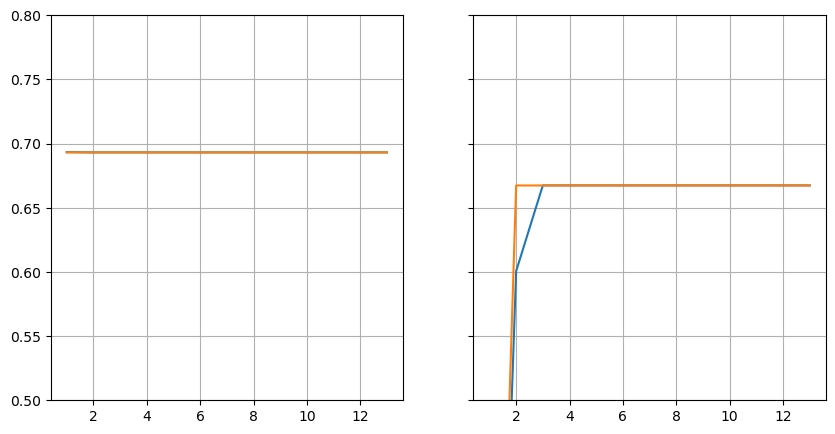

In [54]:
#학습 결과 확인(학습과 검증의 Loss, 성능지표 변화 확인) w. 시각화

th=len(score_history[1])
fg,axes=plt.subplots(1,2,figsize=(10,5),sharey=True)
axes[0].plot(range(1,th+1),loss_history[0][:th],label='Train')
axes[0].plot(range(1,th+1),loss_history[1][:th],label='Val')
axes[0].set_ylim([0.5,0.8])
axes[0].grid()
axes[0].legend

axes[1].plot(range(1,th+1),score_history[0][:th],label='Train')
axes[1].plot(range(1,th+1),score_history[1][:th],label='Val')
axes[1].grid()
axes[1].legend

plt.show()